#  Pathway Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load TCGA+TARGET+GTEX

In [2]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")

## Ingest Pathways

Load gene sets downloaded from msigdb filter out data to only include gene's present in the union of all the pathways

In [3]:
# Load gene sets from downloaded MSigDB gmt file
# KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                 for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop  genes not in X - sort so order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values])
             for name, genes in gene_sets.items()}

# Find union of all gene's in all gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


## Wrangle Labels

Convert tumor/normal, primary site and disease into one hot outputs and combine into a single multi-class multi-label output vectoro to train against.

In [4]:
# Convert  primary_site into numerical values for one-hot multi-class training
from sklearn.preprocessing import LabelEncoder

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["primary_site"]), index=Y.index)

disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(
    disease_encoder.fit_transform(Y["disease"]), index=Y.index)

Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value,disease_value
count,19126,19126,19126,19126,19126,19126,19126,19126.000000,19126.000000,19126.000000
unique,93,93,46,16,3,3,2,NaN,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550559,20.651992,48.639757
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497450,12.419634,25.847654
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000,51.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000,92.000000


In [5]:
# Create a multi-class one hot output all three classifications
from keras.utils import np_utils
Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    np_utils.to_categorical(Y["primary_site_value"]), axis=1)
Y_onehot = np.append(Y_onehot,
    np_utils.to_categorical(Y["disease_value"]), axis=1)
print(Y_onehot.shape)

(19126, 140)


## Stratify Split into Train/Test

Split the data into training and test sets stratified by primary side. Check that we get a good distribution of both primary site and disease between each of these sets.

In [6]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    y_train = Y_onehot[train_index]
    y_test = Y_onehot[test_index]
    primary_site_train = Y["primary_site_value"].values[train_index]
    primary_site_test = Y["primary_site_value"].values[test_index]
    disease_train = Y["disease_value"].values[train_index]
    disease_test = Y["disease_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


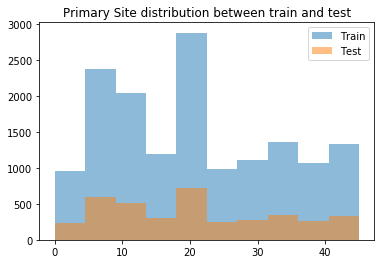

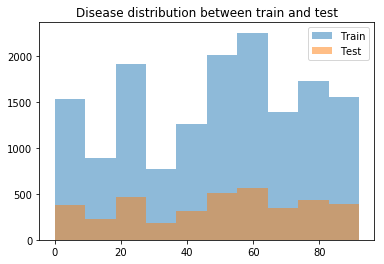

In [7]:
# Lets see how big each class is based on primary site
plt.hist(primary_site_train, alpha=0.5, label='Train')
plt.hist(primary_site_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

# Lets see how big each class is based on primary site
plt.hist(disease_train, alpha=0.5, label='Train')
plt.hist(disease_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test")
plt.show()

## Primary Site Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [8]:
# Convert list of gene names into list of indexes into  features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes)
                    for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:",
      gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


In [248]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

# """
# Build per pathway sub-networks
# """
# # Set to a small number (~4) for debugging, set to None to build all pathways
# # max_num_pathways = 4
# max_num_pathways = None

# # Extract features/gene's for each pathway from the aggregate x input vector
# pathways = [Lambda(lambda x:
#                    K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
#             for name, indexes in
#             itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# # Add a dense layer per pathway with width proportional to the number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p)
#             for p, i in zip(pathways, gene_set_indexes.values())]

# # Add a named binary output for each pathway
# # pathways = [Dense(1, activity_regularizer=regularizers.l1(1e-5),
# #                   activation='relu', name=name)(p)
# #             for p, name in zip(pathways, gene_set_indexes.keys())]

# pathways = [Dropout(0.5)(Dense(1, activity_regularizer=regularizers.l1(1e-5), 
#                                activation='relu', name=name)(p))
#             for p, name in zip(pathways, gene_set_indexes.keys())]

# # Concatenate binary outputs of each of  sub-networks back into single vector
# x = keras.layers.concatenate(pathways)

"""
Add traditional stacked network for final multi-label classification
"""

x = BatchNormalization()(main_input)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activity_regularizer=regularizers.l1(1e-5), activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[predictions])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum(
    [np.product(v.shape) for v in model.trainable_weights]).value)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

Trainable params:: 707060
Epoch 1/10
15300/15300 [==============================] - 46s 3ms/step - loss: 0.2951 - acc: 0.9232
Epoch 2/10
15300/15300 [==============================] - 4s 262us/step - loss: 0.1466 - acc: 0.9845
Epoch 3/10
15300/15300 [==============================] - 3s 197us/step - loss: 0.1255 - acc: 0.9857
Epoch 4/10
15300/15300 [==============================] - 3s 199us/step - loss: 0.1138 - acc: 0.9863
Epoch 00004: early stopping
3826/3826 [==============================] - 20s 5ms/step
['loss', 'acc'] [0.05127492548982572, 0.9892857167275863]
CPU times: user 3min 21s, sys: 8min 17s, total: 11min 39s
Wall time: 1min 16s


## Evaluate Model

In [249]:
%%time
predictions = model.predict(X_test)

CPU times: user 26 s, sys: 5.63 s, total: 31.6 s
Wall time: 22 s


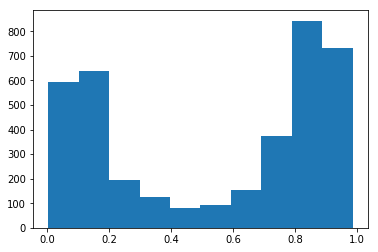

In [250]:
# First lets look at the distribution of our binary tumor/normal predictions
plt.hist(predictions[:,0])
plt.show()

In [251]:
# Let's eye ball the top three predictions against ground truth
labels = primary_site_encoder.classes_.tolist()
[(labels[primary_site_test[i]], ", ".join(["{}({:0.2f})".format(labels[i], p[1:1+46][i])
            for i in p[1:1+46].argsort()[-3:][::-1]]))
 for i, p in enumerate(predictions)][0:-1:200]

[('Skin', 'Skin(0.63), Colon(0.06), Blood Vessel(0.04)'),
 ('Paraganglia', 'Paraganglia(0.14), Kidney(0.11), Skin(0.10)'),
 ('Brain', 'Brain(0.76), Heart(0.07), Kidney(0.04)'),
 ('Skin', 'Skin(0.59), Kidney(0.17), Lung(0.08)'),
 ('Skin', 'Skin(0.59), Colon(0.08), Brain(0.05)'),
 ('Stomach', 'Stomach(0.30), Colon(0.13), Lung(0.13)'),
 ('Soft tissue,Bone', 'Brain(0.11), Lung(0.10), Kidney(0.09)'),
 ('Vagina', 'Esophagus(0.27), Blood(0.11), Thyroid(0.07)'),
 ('Lung', 'Lung(0.59), Head and Neck region(0.04), Esophagus(0.04)'),
 ('Adrenal Gland', 'Esophagus(0.24), Lung(0.19), Breast(0.17)'),
 ('Lung', 'Lung(0.35), Head and Neck region(0.06), Esophagus(0.06)'),
 ('Heart', 'Heart(0.40), Muscle(0.07), Thyroid(0.06)'),
 ('Pituitary', 'Breast(0.21), Adipose Tissue(0.14), Lung(0.10)'),
 ('Ovary', 'Ovary(0.34), Thyroid Gland(0.08), Lung(0.02)'),
 ('Pancreas', 'Brain(0.29), Kidney(0.13), Lung(0.13)'),
 ('White blood cell', 'White blood cell(0.50), Kidney(0.15), Liver(0.09)'),
 ('Breast', 'Breast(0.

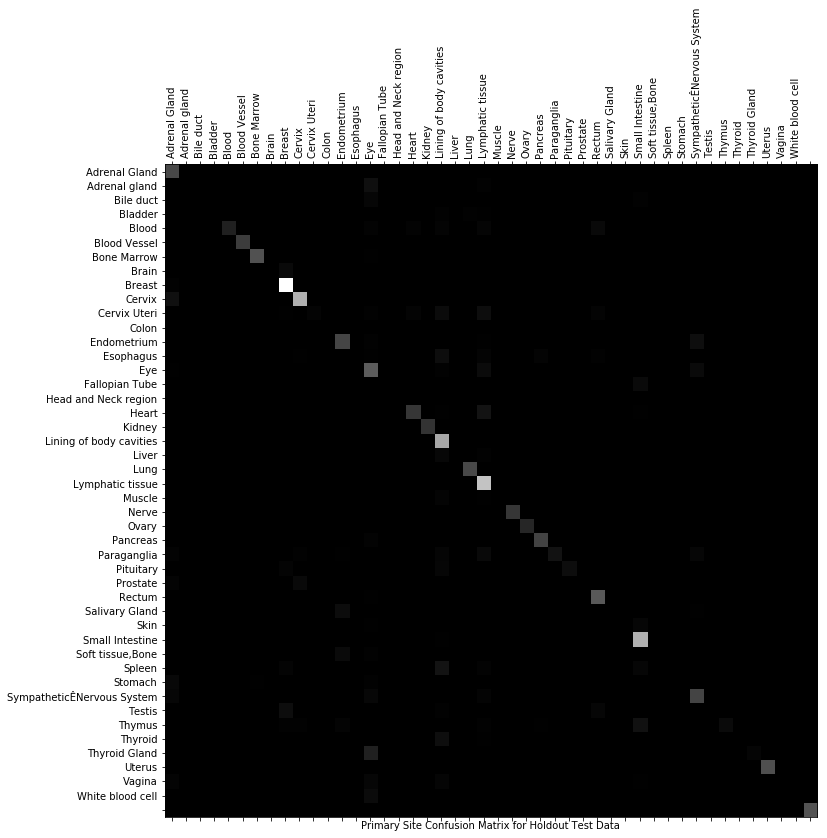

In [252]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    primary_site_test, np.array([np.argmax(p[1:1+46]) for p in predictions]))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Confusion Matrix for Holdout Test Data")
plt.show()

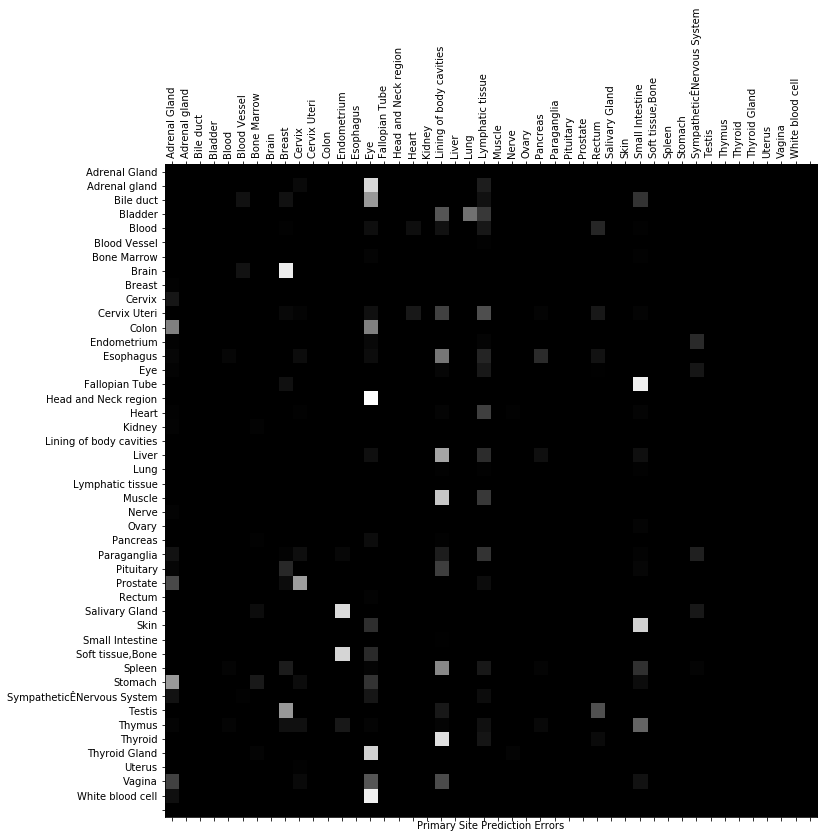

In [253]:
# Show only where there are errors
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Prediction Errors")
plt.show()